# How to analyse metabolic networks with Maud

This notebook explains how to use [Maud](https://github.com/biosustain/Maud/) to fit Bayesian statistical models of steady-state metabolic networks, and how to investigate the results.

## Wait, are you in read-only mode??

If you don't see a crossed-out floppy disc in the top right of this window, then everything is probably fine: please skip to the next section.

If you do see a crossed-out floppy disk, you may have opened this file from the read-only `shared` folder. 

Don't worry! All you need to do is go to the "Home Page" tab, open a terminal by clicking "New" and then "terminal", and then running the following command to copy the demo material into the writeable `work` folder:

```sh
cp -r shared/maud_demo work
```

Now go back to the "Home Page" tab and click "maud_demo" then "demo.ipynb".

## Jupyter notebook basics

This is an interactive [Jupyter notebook](https://jupyter-notebook.readthedocs.io/en/stable/) running a Python 3.9 kernel. Here are some quick instructions that should get you through the demo if you haven't used one of these before.

In code cells you can write Python code and also [Ipython magic commands](https://ipython.readthedocs.io/en/stable/interactive/magics.html). In particular, Ipython magic allows shell commands to be run by appending `!`.

In markdown cells you can write markdown text.

To edit a cell, just click inside of it and type. To focus a cell without editing it, click on the white area immediately to the left of it.

To run a code cell or display a markdown cell, make sure it is focussed (if a cell is focussed there should be a green or blue box around it), then click the `▶ Run` button above or press `control-return`. Any output should then appear below the executed cell.

To stop a running cell, click the `◼` button.

To restart the Python process, click the `Kernel` button and then `Restart`.

To find out more about Jupyter notebooks, check out the [documentation](https://jupyter-notebook.readthedocs.io/en/stable/) or click the `Help` button above.


## An example Maud input

We have prepared a simple dataset for you to analyse. The target system looks like this:

![](data/linear/linear.svg)

It's a very small and simple linear network of three reversible reactions, with three modifications (one case of allosteric activation, one of allosteric inhibition and one of competitive inhibition).

To start with we'll look through the files in one of the example datasets we have provided. 

You can find a discussion of the input data format in Maud's documentation [here](https://maud-metabolic-models.readthedocs.io/en/latest/usage/inputting.html), but this guide should be enough to get started.

First let's check out the contents of the folder `data/linear` by running the first cell below.

In [1]:
!ls data/linear

config.toml             linear.json             true_params_linear.json
experiments.csv         linear.svg
kinetic_model.toml      priors.csv


The most important of these files, and the only one whose name is important, is `config.toml`. This file tells Maud where to look for the other files it needs, and stores some configuration information that is passed on to Stan. 

Here is what our example config file looks like:

In [2]:
!cat data/linear/config.toml

name = "linear"
kinetic_model = "kinetic_model.toml"
priors = "priors.csv"
experiments = "experiments.csv"
likelihood = true

[cmdstanpy_config]
iter_warmup = 500
iter_sampling = 500
chains = 4
max_treedepth = 10
refresh = 1
save_warmup = true
show_progress = true
adapt_delta = 0.8

[ode_config]
abs_tol_forward = 1e-4
rel_tol_forward = 1e-4
abs_tol_backward = 1e-4
rel_tol_backward = 1e-4
abs_tol_quadrature = 1e-4
rel_tol_quadrature = 1e-4
max_num_steps = 1e6
timepoint = 1e3



The first few lines of this file define top-level fields. These tell Maud where to look for the files it needs, and do some high level configuration (`name` picks a name for the input and `likelihood` tells Maud whether or not to run in priors-only mode).

The second section defines a table called `cmdstanpy_config`. Each field here specifies a keyword argument to [cmdstanpy's `sample` method](https://cmdstanpy.readthedocs.io/en/v0.9.77/api.html#cmdstanpy.CmdStanModel.sample). In this case we tell Stan to run 4 markov chains, each of which should use 200 iterations in both its warmup and sampling phases, and to save both warmup and sampling draws in its output csv files.

The fields in the final section specify tuning parameters for the Stan function [`ode_adjoint_tol_ctl`](https://mc-stan.org/docs/2_27/functions-reference/functions-ode-solver.html#adjoint-sensitivity-solver), except for `timepoint`, which tells Maud how long to simulate this function for.



Now let's look at the other files in the folder, starting with `kinetic_model.toml`.

In [3]:
!cat data/linear/kinetic_model.toml

###### Kinetic model ######
[[compartments]]
id = 'c'
name = 'cytosol'
volume = 1

[[compartments]]
id = 'e'
name = 'external'
volume = 1

[[metabolites]]
id = 'M1'
name = 'External metabolite number 1'
balanced = false
compartment = 'e'

[[metabolites]]
id = 'M2'
name = 'External metabolite number 2'
balanced = false
compartment = 'e'

[[metabolites]]
id = 'M1'
name = 'Metabolite number 1'
balanced = true
compartment = 'c'

[[metabolites]]
id = 'M2'
name = 'Metabolite number 2'
balanced = true
compartment = 'c'

[[reactions]]
id = 'r1'
name = 'reaction number 1'
stoichiometry = { M1_e = -1, M1_c = 1}
mechanism = "reversible_modular_rate_law"
[[reactions.enzymes]]
id = 'r1'
name = 'the enzyme that catalyses reaction r1'
[[reactions.enzymes.modifiers]]
modifier_type = 'allosteric_activator'
mic_id = 'M2_c'

[[reactions]]
id = 'r2'
name = 'reaction number 2'
stoichiometry = { M1_c = -1, M2_c = 1 }
mechanism = "reversible_modular_rate_law"
[[reactions.enzymes]]
id = 'r2'
name = 'the enzym

This file consists of a table of `compartments`, a table of `metabolites` and a table of `reactions`.

Next let's have a look at the model's priors and measurements.

In [4]:
import pandas as pd
from IPython.display import display

priors = pd.read_csv("data/linear/priors.csv")
experiments = pd.read_csv("data/linear/experiments.csv")

print("Experiments:")
display(experiments)
print("Priors:")
display(priors)

Experiments:


,measurement_type,target_id,experiment_id,measurement,error_scale
0,mic,M1_c,condition_1,0.70,0.10
1,mic,M2_c,condition_1,0.40,0.10
2,mic,M1_e,condition_1,0.50,0.10
3,mic,M2_e,condition_1,0.10,0.10
4,flux,r3,condition_1,0.29,0.10
5,enzyme,r1,condition_1,1.00,0.05
6,enzyme,r2,condition_1,1.00,0.05
7,enzyme,r3,condition_1,1.00,0.05
8,mic,M1_c,condition_2,0.50,0.10
9,mic,M2_c,condition_2,0.40,0.10


Priors:


,parameter_type,metabolite_id,mic_id,enzyme_id,drain_id,experiment_id,location,scale,pct1,pct99
0,kcat,NaN,NaN,r1,NaN,NaN,2.0,0.60,NaN,NaN
1,kcat,NaN,NaN,r2,NaN,NaN,1.0,0.60,NaN,NaN
2,kcat,NaN,NaN,r3,NaN,NaN,1.0,0.60,NaN,NaN
3,km,NaN,M1_e,r1,NaN,NaN,0.2,0.60,NaN,NaN
4,km,NaN,M1_c,r1,NaN,NaN,0.2,0.60,NaN,NaN
5,km,NaN,M1_c,r2,NaN,NaN,0.2,0.60,NaN,NaN
6,km,NaN,M2_c,r2,NaN,NaN,0.2,0.60,NaN,NaN
7,km,NaN,M2_c,r3,NaN,NaN,0.2,0.60,NaN,NaN
8,km,NaN,M2_e,r3,NaN,NaN,0.2,0.60,NaN,NaN
9,conc_unbalanced,NaN,M1_e,NaN,NaN,condition_1,0.5,0.20,NaN,NaN


## Checking how our model behaves at the initial parameter values

Rather than going straight ahead and sampling, we usually prefer to run a single, fixed-parameter HMC iteration at the initial parameter values and inspect the results before proceeding futher, using the command `maud simulate`. By default Maud initialises at the prior mean, but initial values can also be specified.

The main reason for running `maud simulate` before sampling is to quickly catch cases where the sampler has difficulty traversing the posterior distribution early in the run. This might be due to an error in the provided input data, in which case it is quite likely that the printed output will be weird in a way that makes it easier to track down the problem. Alternatively, it could be that the prior mean happens to be near a natural saddle point or other tricky part of the posterior distribution. In this case it might be necessary to specify custom initial values.

In [5]:
!maud simulate data/linear

Creating output directory: ./maud_output_sim-linear-20210919171357
Copying user input from data/linear to ./maud_output_sim-linear-20210919171357/user_input
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /Users/tedgro/Code/Maud/src/maud/model
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:finish chain 1

Simulated concentrations and fluxes:
experiments  mics
condition_1  M1_c    0.369406
             M1_e    0.500000
             M2_c    0.207278
             M2_e    0.100000
condition_2  M1_c    0.433708
             M1_e    0.600000
             M2_c    0.224985
             M2_e    0.100000
Name: conc, dtype: float64
experiments  reactions
condition_1  r1           0.045357
             r2           0.045357
             r3           0.045357
condition_2  r1           0.051061
             r2           0.051061
             r3           0.051061
Name: flux, dtype: float64
experiments  enzymes
condition_1  r1         0.214476
             r2    

This command did a few things: it created an output directory in starting with `maud_output_sim-linear`, fetched data from our input folder, converted the data into a Stan-compatible json file, compiled Maud's Stan program into an executable, then ran one iteration of Stan's sampler in fixed-parameter mode and printed some results.

Looking at the steady state metabolite concentrations, fluxes and enzyme concentrations, we can see that none of them are wildly implausible. This is nice, as starting the sampler at a very unrealistic point can lead to poor performance.

However, the simulated concentrations are fairly far away from the measurements, as indicated by the low values of some of the `log-lik-conc` variables.

If we want to inspect the simulation output more closely, we can do so by examining the files in the output folder.

## Generating posterior draws

Since the initial conditions looked ok, it seems safe to start sampling. This can be done with the command `maud sample`.

Since, even for this small system, the sampling step takes some time, we recommend running kick this command off in a separate terminal rather than using Ipython magic, as this leaves our Python kernel free. 

You should already have a terminal open from earlier in the demo, but if not, just click on the `Home` tab, then `New` and then `terminal`.

Now run the following command:

```sh
maud sample data/linear
```

This should do the same things as the `simulate` command we ran above, but instead of running in fixed-parameter mode, this time Stan will attempt to explore our whole parameter space, saving some posterior draws in a new output directory starting with `maud_output-linear-`, and then running some diagnostics. 

Don't worry if the diagnostics complain: this is expected! There weren't enough warmup iterations for the sampler to learn the geometry of the posterior distribution, or enough post-warmup iterations to overcome the Monte Carlo error. 

Luckily we prepared a good run earlier - you can find it at `data/example_output_linear`.

## Analysing the run

First let's look at the output directory

In [6]:
!tree data/example_output_linear/

data/example_output_linear/
├── infd.nc
├── samples
│   ├── coords.json
│   ├── inits.json
│   ├── input_data.json
│   ├── model-202109161702-1-stdout.txt
│   ├── model-202109161702-1.csv
│   ├── model-202109161702-2-stderr.txt
│   ├── model-202109161702-2-stdout.txt
│   ├── model-202109161702-2.csv
│   ├── model-202109161702-3-stderr.txt
│   ├── model-202109161702-3-stdout.txt
│   ├── model-202109161702-3.csv
│   ├── model-202109161702-4-stdout.txt
│   ├── model-202109161702-4.csv
│   ├── model-202109191632-1-stderr.txt
│   ├── model-202109191632-1-stdout.txt
│   ├── model-202109191632-1.csv
│   ├── model-202109191632-2-stdout.txt
│   ├── model-202109191632-2.csv
│   ├── model-202109191632-3-stdout.txt
│   ├── model-202109191632-3.csv
│   ├── model-202109191632-4-stderr.txt
│   ├── model-202109191632-4-stdout.txt
│   └── model-202109191632-4.csv
└── user_input
    ├── config.toml
    ├── experiments.csv
    ├── kinetic_model.toml
    ├── linear.json
    ├── linear.svg
    ├── priors.c

The folder `user_input` is a copy of the input directory, i.e. `data/linear`.

The folder `samples` contains the Stan csv and debug files, as well as some json files. The `txt` files can be useful to inspect - for example, if the system ever fails to reach a steady state, a warning message will be printed here. `input_data.json` is the input for Maud's Stan program - it can be useful to inspect for debugging purposes. `inits.json` contains the initial parameter values, i.e. the state where Stan's sampler began. This is very useful to inspect when the sampler is having difficulty initialising. Finally, `coords.json` contains lists of strings that map the stan variables' indexes to meaningful names.

The file `infd.nc` is an [InferenceData](https://arviz-devs.github.io/arviz/schema/schema.html) object from the Python library [Arviz](https://arviz-devs.github.io/arviz/), saved in [netcdf](https://www.unidata.ucar.edu/software/netcdf/) format. This is the most useful file for inspecting and analysing the results of a Maud run. 

The next cell uses arviz to load `infd.nc` and inspects it.


In [7]:
import os

import arviz as az

output_dir = "data/example_output_linear/"  # change this if you want to analyse a different output

infd = az.from_netcdf(os.path.join(output_dir, "infd.nc"))

infd

Inference data with groups:
	> posterior
	> sample_stats

Warmup iterations saved (warmup_*).

The first step is to check that our run. First we check whether there were any diverging transitions.

In [8]:
infd.sample_stats["diverging"].values.sum()

0

Next we check whether any variables' [rhat statistics](https://avehtari.github.io/rhat_ess/rhat_ess.html) were far from 1.

In [9]:
summary = az.summary(infd, extend=True)

summary["r_hat"].subtract(1).abs().max(), summary["r_hat"].subtract(1).abs().idxmax()

/Users/tedgro/Code/Maud/maud_venv/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/tedgro/Code/Maud/maud_venv/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


(0.010000000000000009, 'log_conc_enzyme_z[1,1]')

Finally, we can eyeball some rank plots - if the model has converged there should be no non-random deviations from a uniform distribution.

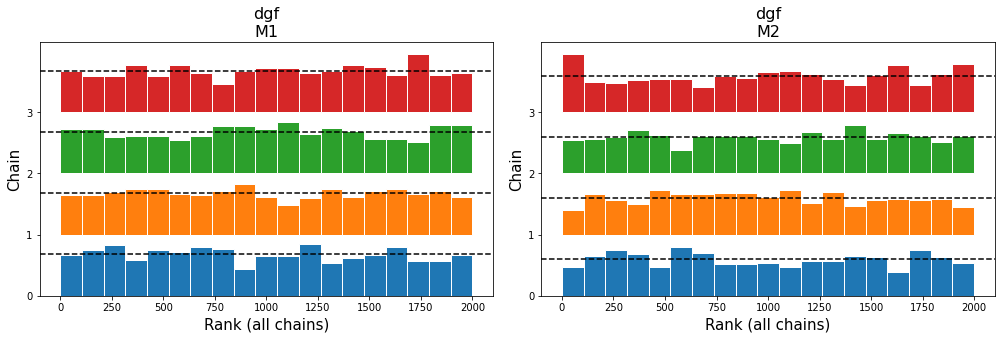

In [10]:
axes = az.plot_rank(infd, var_names=["dgf"])

As well as providing a platform-agnostic data structure for MCMC software, arviz also offers some very useful plotting functions that interoperate nicely with standard data visualisation tools like matplotlib.

The cell below plots the posterior metabolite and enzyme concentrations for our run.

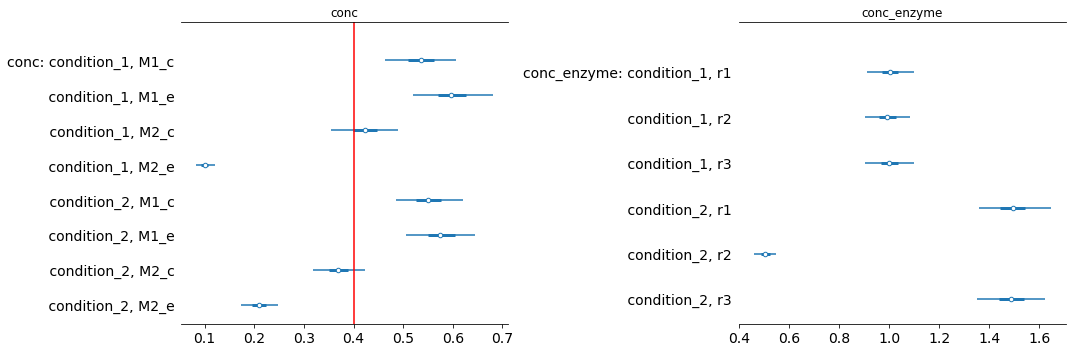

In [11]:
from matplotlib import pyplot as plt

f, axes = plt.subplots(1, 2, figsize=[15, 5])

for i, var in enumerate(["conc", "conc_enzyme"]): 
    ax = az.plot_forest(infd.posterior[var], combined=True, kind="forestplot", ax=axes[i])[0]
    ax.set_title(var)

line = axes[0].axvline(0.4, color="red")

plt.tight_layout()

The arviz function `plot_pair` is particularly useful for showing relationships between different parameters. Here we plot the draws for the $k_{cat}$ and flux parameters for the reaction r2 on log scale.

As you would expect, draws with higher $k_{cat}$ values also tend to have higher flux. Interestingly, the correlation between the flux between the two experimental conditions is noticeably greater than the correlations involving $k_{cat}$. This suggests that there another parameter is controlling the flux of this reaction more strongly than its $k_{cat}$ parameter.

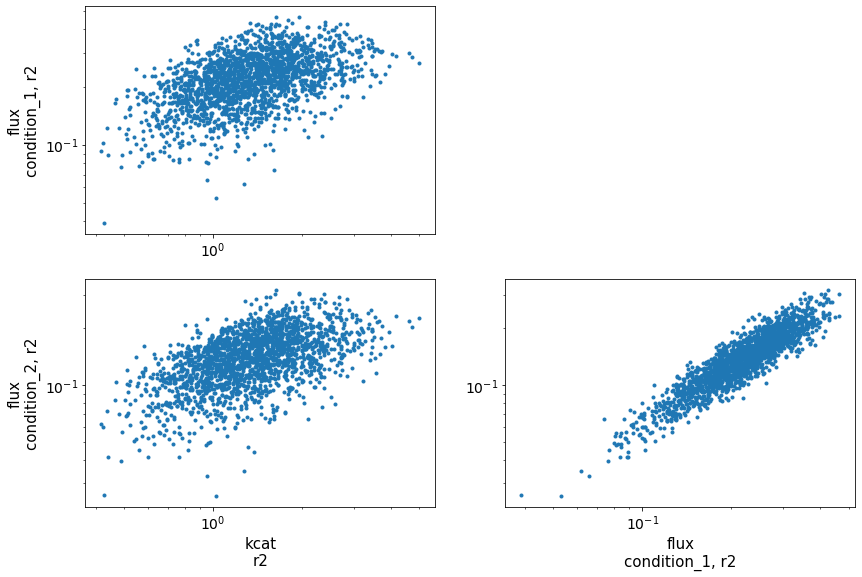

In [12]:
axes = az.plot_pair(
    infd.posterior,
    var_names=["kcat", "flux"], 
    coords={"enzymes": ["r2"], "reactions": ["r2"]}
)
axes = axes.ravel()
for ax in axes:
    ax.semilogx()
    ax.semilogy()

## Exercise: a more realistic example

You may have noticed that the `data` directory contains another directory that we haven't looked at yet, called `input_G6Pto6PGC`.

This dataset is more realistic than the toy example we have been looking at so far, representing the first two reactions in the [pentose phosphate pathway](https://en.wikipedia.org/wiki/Pentose_phosphate_pathway).

If you've finished following the notebook and would like to experience the thrill of a more realistic Maud investigation, the final challenge of the workshop is to fit this dataset.

Feel free to edit any of the files - for example you might want to change the priors, add, edit or remove measurements, or experiment with different configuration options. I suggest using the editor nano for this task as I had some trouble using vim using the Jupyter terminal interface.